In [170]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import bayesflow as bf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Two choice task (Racing diffusion model)

We’ll assume a simple RDM with two choice alternatives (Tillman et al.,
2020).

Here we will simplify the model to include no bias, no variability in
starting points. Instead of modeling one accumulator for each of \[left,
right\] responses, we will simply model one accumulator for “incorrect”
and one accumulator for “correct” response. This makes it a bit easier
to simulate from (we do not need to simulate stimuli).

Additionally, we assume that the decision threshold is a function of time.
Specifically, this means that the decision threshold decreases linearly with 
trial number, according to threshold = $\alpha$ + $\beta$*trial.

The model has four parameters: 2 drift rates (incorrect - $\nu_0$,
correct $\nu_1$), decision threshold intercept $\alpha$, decision threshold slope $\beta$#, and non-decision time
$\tau$.

In [175]:
def evidence_accumulation(nu, max_t, dt):
    timesteps = int(max_t / dt)
    t = np.linspace(0, max_t, timesteps)

    noise = np.random.normal(0, 1, size=timesteps) * np.sqrt(dt)
    evidence = nu * t + np.cumsum(noise)

    return t, evidence

def context(n=None):
    if n is None:
        n = np.random.randint(200, 201)
    return dict(n=n)

def prior(nu=None, alpha=None, beta=None, tau=None):
    if nu is None:
        nu=np.random.dirichlet([2, 2])
        nu=np.random.gamma(shape=5, scale=0.5) * nu
    if alpha is None:
        alpha=np.random.gamma(shape=5, scale=0.2)
    if beta is None:
        beta=np.random.beta(a=1, b=1)* -0.01
    if tau is None:
        tau=np.random.exponential(0.15)
    else:
        tau=tau.item()

    return dict(nu=nu, alpha=alpha, beta=beta, tau=tau)

# generate data for a single trial
def trial(nu, alpha, tau, max_t, dt):
    response = -1
    min_t = max_t
    # loop over accumulators
    # if an accumulator has a smaller passage time than the current minimum
    # save it as the fastest accumulator (response)
    for resp, drift in enumerate(nu):
        t, evidence = evidence_accumulation(drift, max_t, dt)
        passage = np.argmax(evidence > alpha)
        t = max_t if passage==0 else t[passage]
        
        if t < min_t:
            min_t = t
            response = resp
            
    return min_t+tau, response

# generate data for n trials
# keep the data.shape always to max_n
# the rest is filled with 0s
def likelihood(n, nu, alpha, beta, tau, max_t=3.0, dt=0.02, max_n=200):
    rt = np.zeros(max_n)
    response = np.zeros(max_n)
    observed = np.zeros(max_n)
    for i in range(n):
        threshold = alpha + beta * i # LvM: the threshold is a function of the trial number
        # if the treshold is below zero, the participant storms out of the lab because they ran out of patience
        if threshold < 0:
            break
        result = trial(nu, threshold, tau, max_t, dt)
        rt[i] = result[0]
        response[i] = result[1]
        observed[i] = 1

    return dict(rt=rt, response=response, trial=range(n), observed=observed)

simulator = bf.make_simulator([context, prior, likelihood])

In [172]:
adapter = (bf.Adapter()
    .as_set(["rt", "response", "trial", "observed"])
    .constrain(["nu", "alpha", "tau"], lower=0)
    .standardize(include="nu",    mean= 0.7, std=1.2 )
    .standardize(include="alpha", mean= 0.5, std=0.7 )
    .standardize(include="beta",  mean= -.05, std=0.02 )
    .standardize(include="tau",   mean=-2.5, std=1.3 )
    .standardize(include="trial", mean= 100,  std=60  )
    .concatenate(["nu", "alpha","beta", "tau"], into="inference_variables")
    .concatenate(["rt", "response", "trial", "observed"], into="summary_variables")
    .rename("n", "inference_conditions")
)


In [176]:
workflow = bf.BasicWorkflow(
    simulator = simulator,
    adapter = adapter,
    inference_network = bf.networks.CouplingFlow(
        depth=15,
        subnet_kwargs=dict(dropout=False)
    ),
    summary_network=bf.networks.DeepSet(
        depth=15,
        base_distribution="normal",
        dropout=False
    ),
    initial_learning_rate = 1e-3,
    inference_variables = ["nu", "alpha", "beta", "tau"],
    inference_conditions = ["n"],
    summary_variables = ["rt", "response","trial","observed"]
)

In [177]:
train_data = simulator.sample(2_500)
validation_data = simulator.sample(500)
test_data = simulator.sample(500)

In [178]:
history=workflow.fit_offline(
    data=train_data, 
    epochs=50, 
    batch_size=250, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 447s 10s/step - loss: 2481876.2500 - loss/inference_loss: 2481875.7500 - loss/summary_loss: 0.7316 - val_loss: 463.8929 - val_loss/inference_loss: 463.2145 - val_loss/summary_loss: 0.6784
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - loss: 59.6651 - loss/inference_loss: 58.9418 - loss/summary_loss: 0.7233 - val_loss: 11.2292 - val_loss/inference_loss: 10.7928 - val_loss/summary_loss: 0.4364
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - loss: 7.9351 - loss/inference_loss: 7.6685 - loss/summary_loss: 0.2666 - val_loss: 6.5161 - val_loss/inference_loss: 6.3241 - val_loss/summary_loss: 0.1920
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - loss: 6.3099 - loss/inference_loss: 6.1192 - loss/summary_loss: 0.1907 - val_loss: 5.9470 - val_loss/inference_loss: 5.7425 - val_loss/summary_loss: 0.2046
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - loss: 5.9675 - loss/inference_loss: 5.7735 - loss/summary_loss: 0.1940 - val_loss: 6.3504 - va

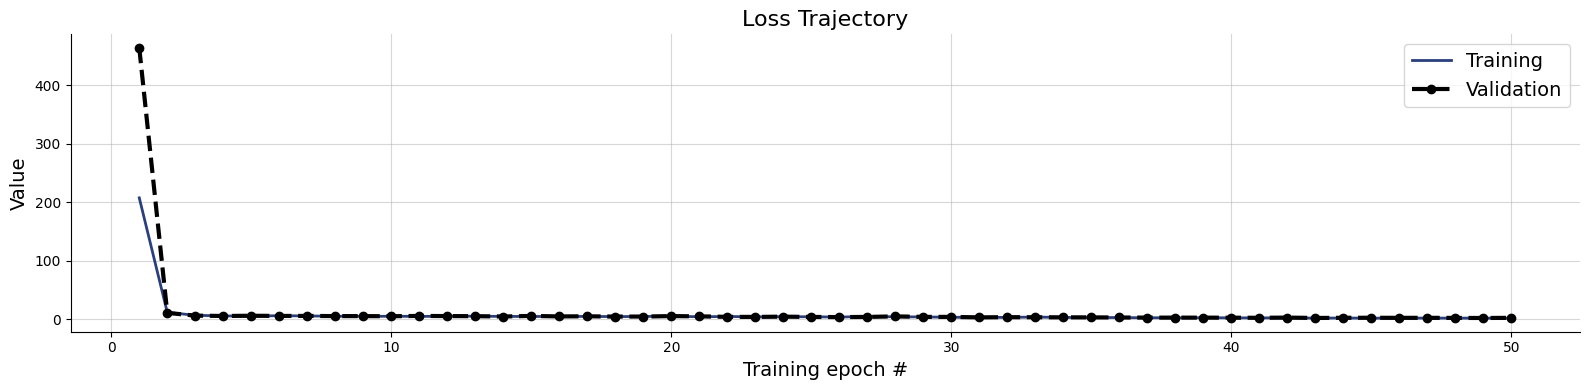

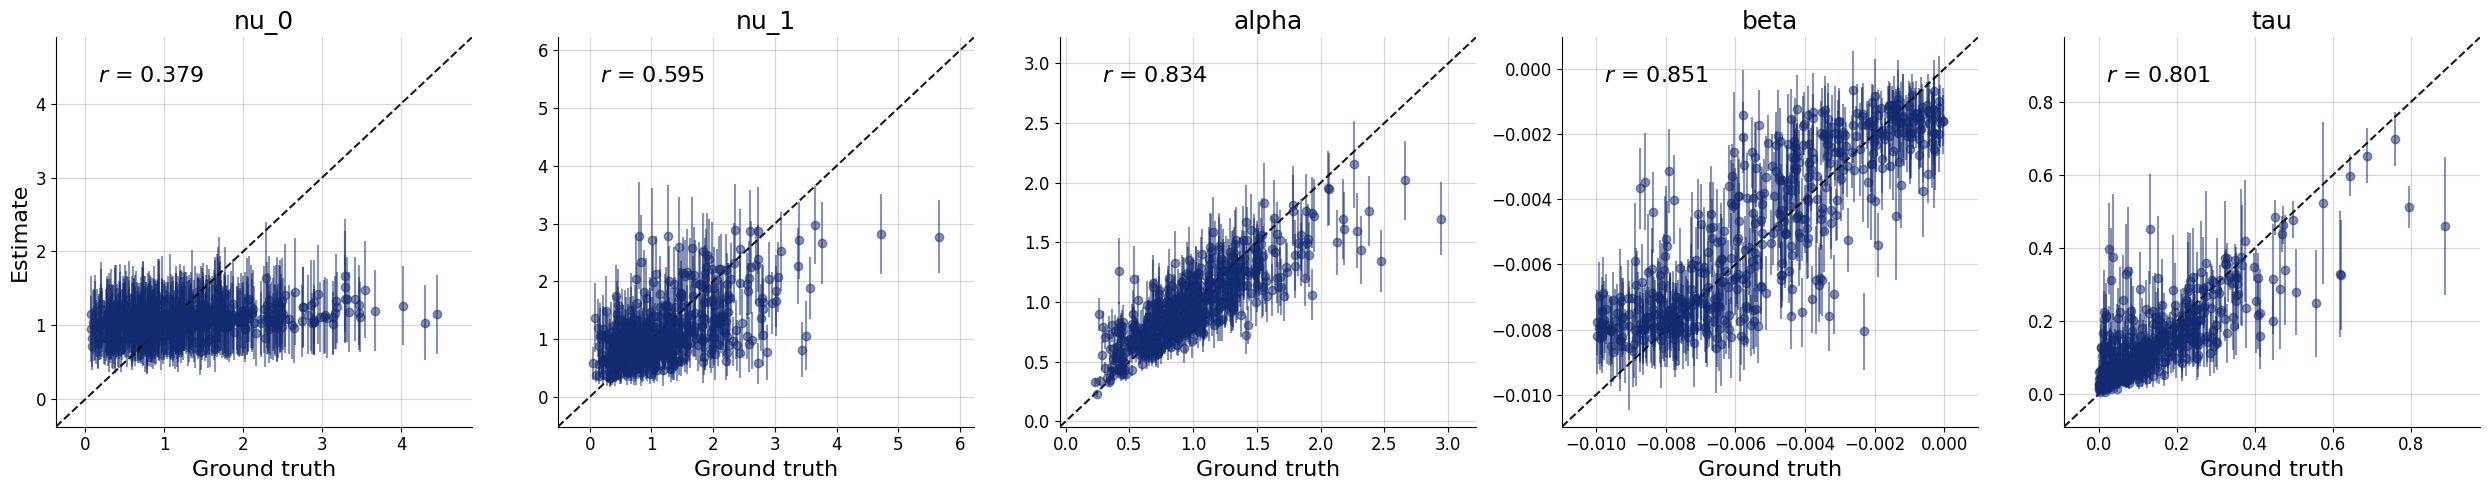

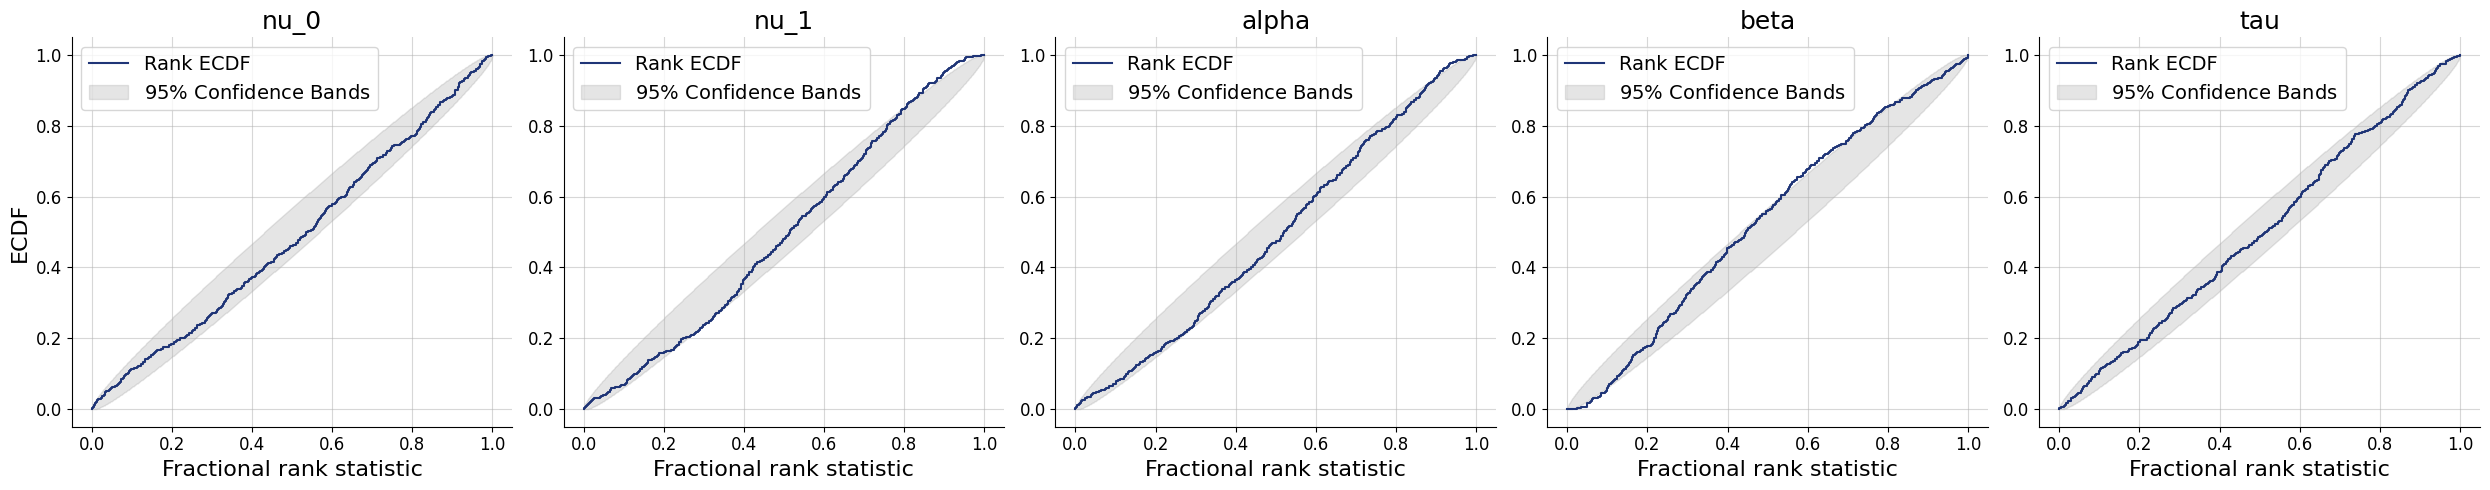

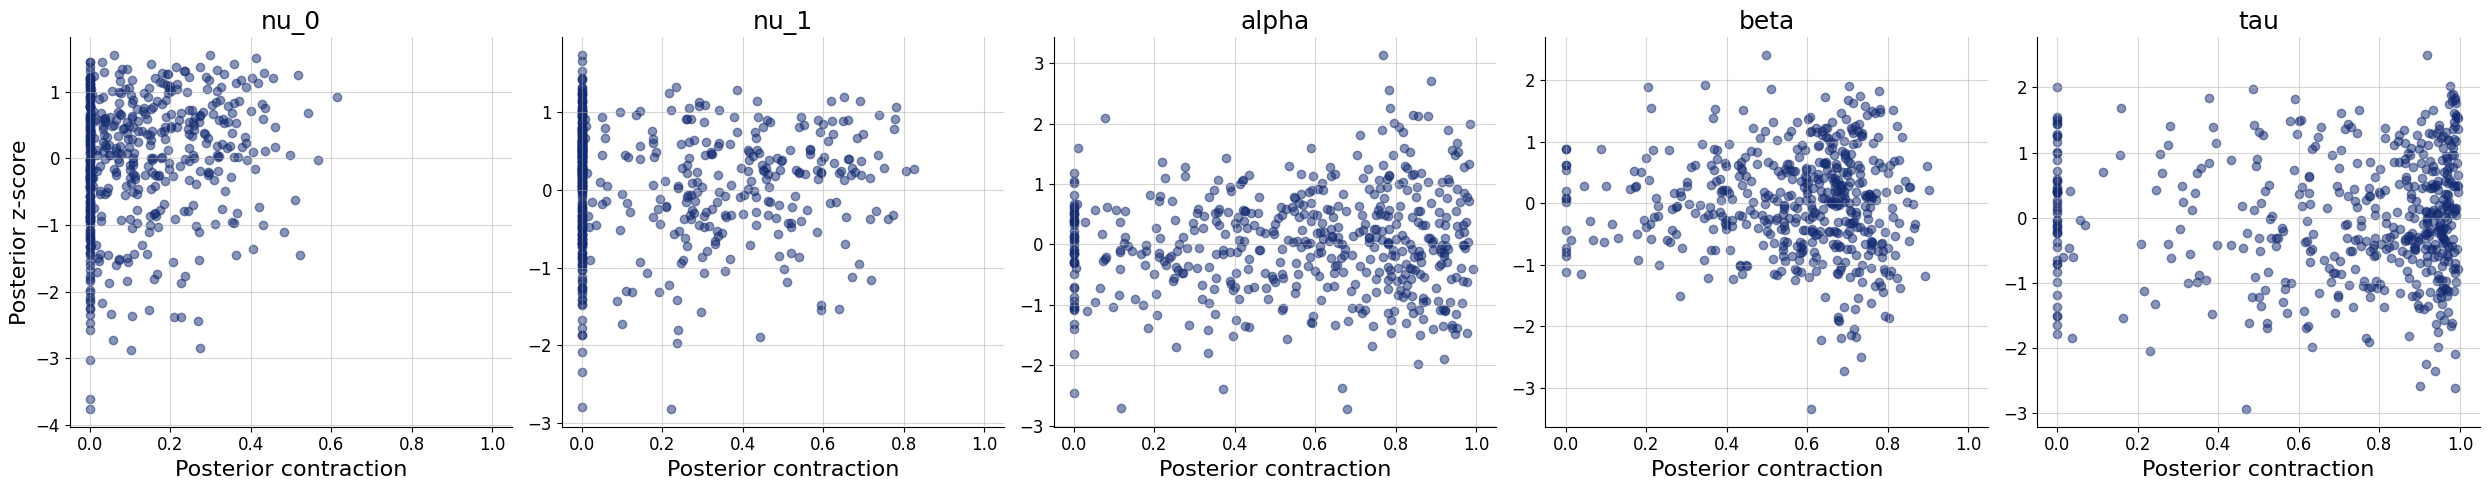

In [179]:
plots=workflow.plot_default_diagnostics(test_data=test_data)

### Application to data

Here we will work with data from Katsimpokis et al (2021), Experiment 2. 
In this experiment, participants are asked to indicate which of two flashing circles 
has the higher flash rate. Additionally, they are either asked to be Fast or Accurate, and 
to respond before a deadline or not, in a full factorial manner. The file `flash.csv` only contains data from the Accuracy instruction.

In [194]:
data_inference = pd.read_csv("flash.csv")

In [195]:
data_inference['condition'].unique()

array(['Deadline', 'No Deadline'], dtype=object)

In [196]:
data_inference_grouped = data_inference.groupby(["subject", "condition"])

In [197]:
data_inference_dict = {
    key: np.array([group[key].values.reshape(200, 1) for _, group in data_inference_grouped]) 
             for key in ['rt', 'response', 'trial','observed']}
data_inference_dict["n"] = np.sum(data_inference_dict["observed"], axis=1)
print({key: value.shape for key, value in data_inference_dict.items()})

{'rt': (48, 200, 1), 'response': (48, 200, 1), 'trial': (48, 200, 1), 'observed': (48, 200, 1), 'n': (48, 1)}


In [198]:
posterior_samples = workflow.sample(conditions=data_inference_dict, num_samples=1000)

In [199]:
# pick the first participant, first condition
posterior = {key: value[0] for key, value in posterior_samples.items()}
posterior['nu'].shape

(1000, 2)

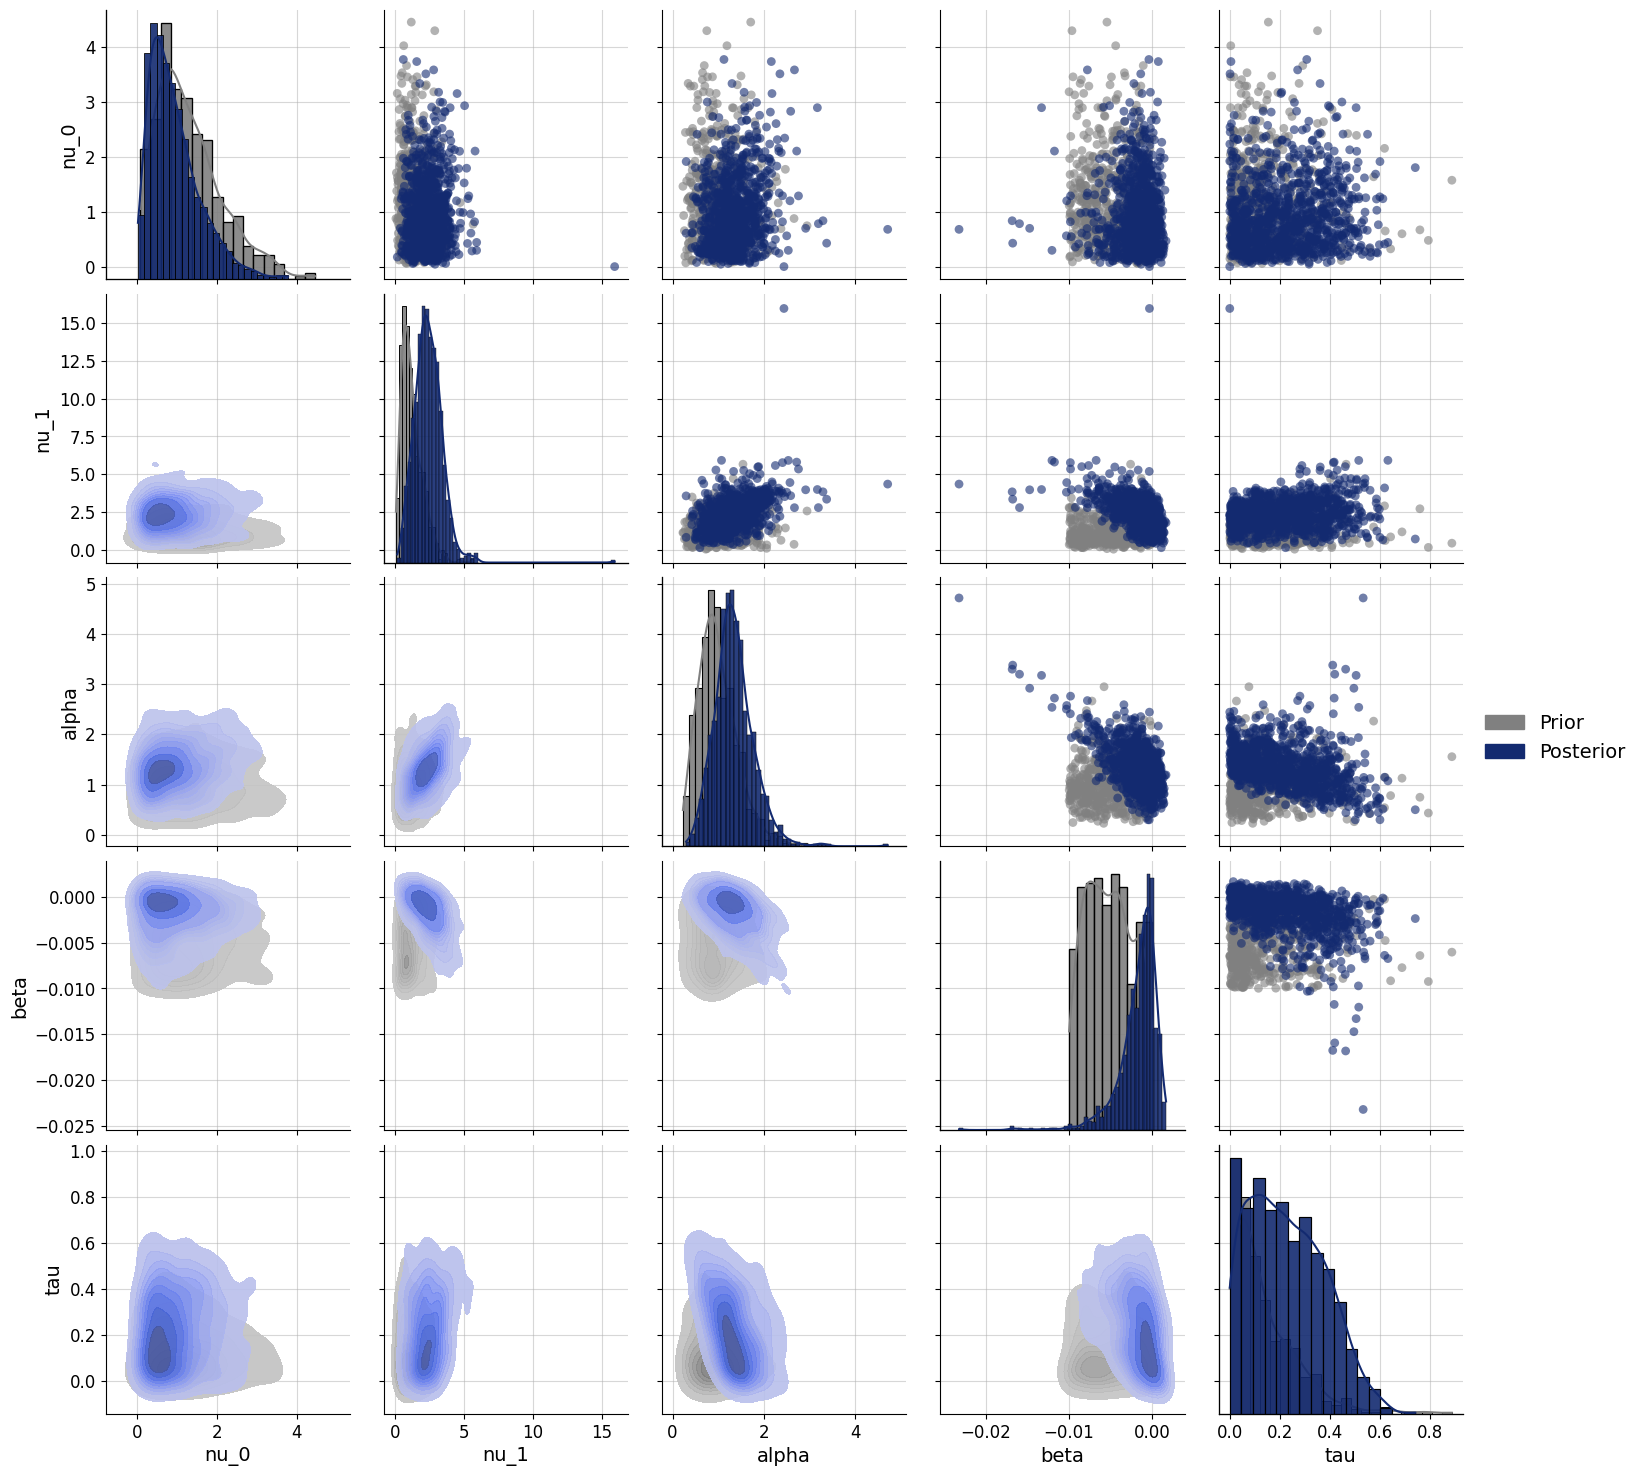

In [227]:
priors = dict(nu=test_data["nu"], alpha=test_data["alpha"], beta=test_data["beta"], tau=test_data["tau"])
f=bf.diagnostics.pairs_posterior(estimates=posterior, priors=priors)

The model is still quite uncertain about the parameter estimates, shown by the large ovelap between prior and posterior. There is a bit of a trade-off in this case between the $\alpha$ and $\beta$ parameters (but not as big as I expected). This is because they jointly explain the same aspect of the data (response caution). A higher $\alpha$ means that on the first trial a participant is more conservative. So to get to the same average level of conservativeness, the $\beta$ needs to be more negative, hence the negative relation.  

Let's look at another participant:

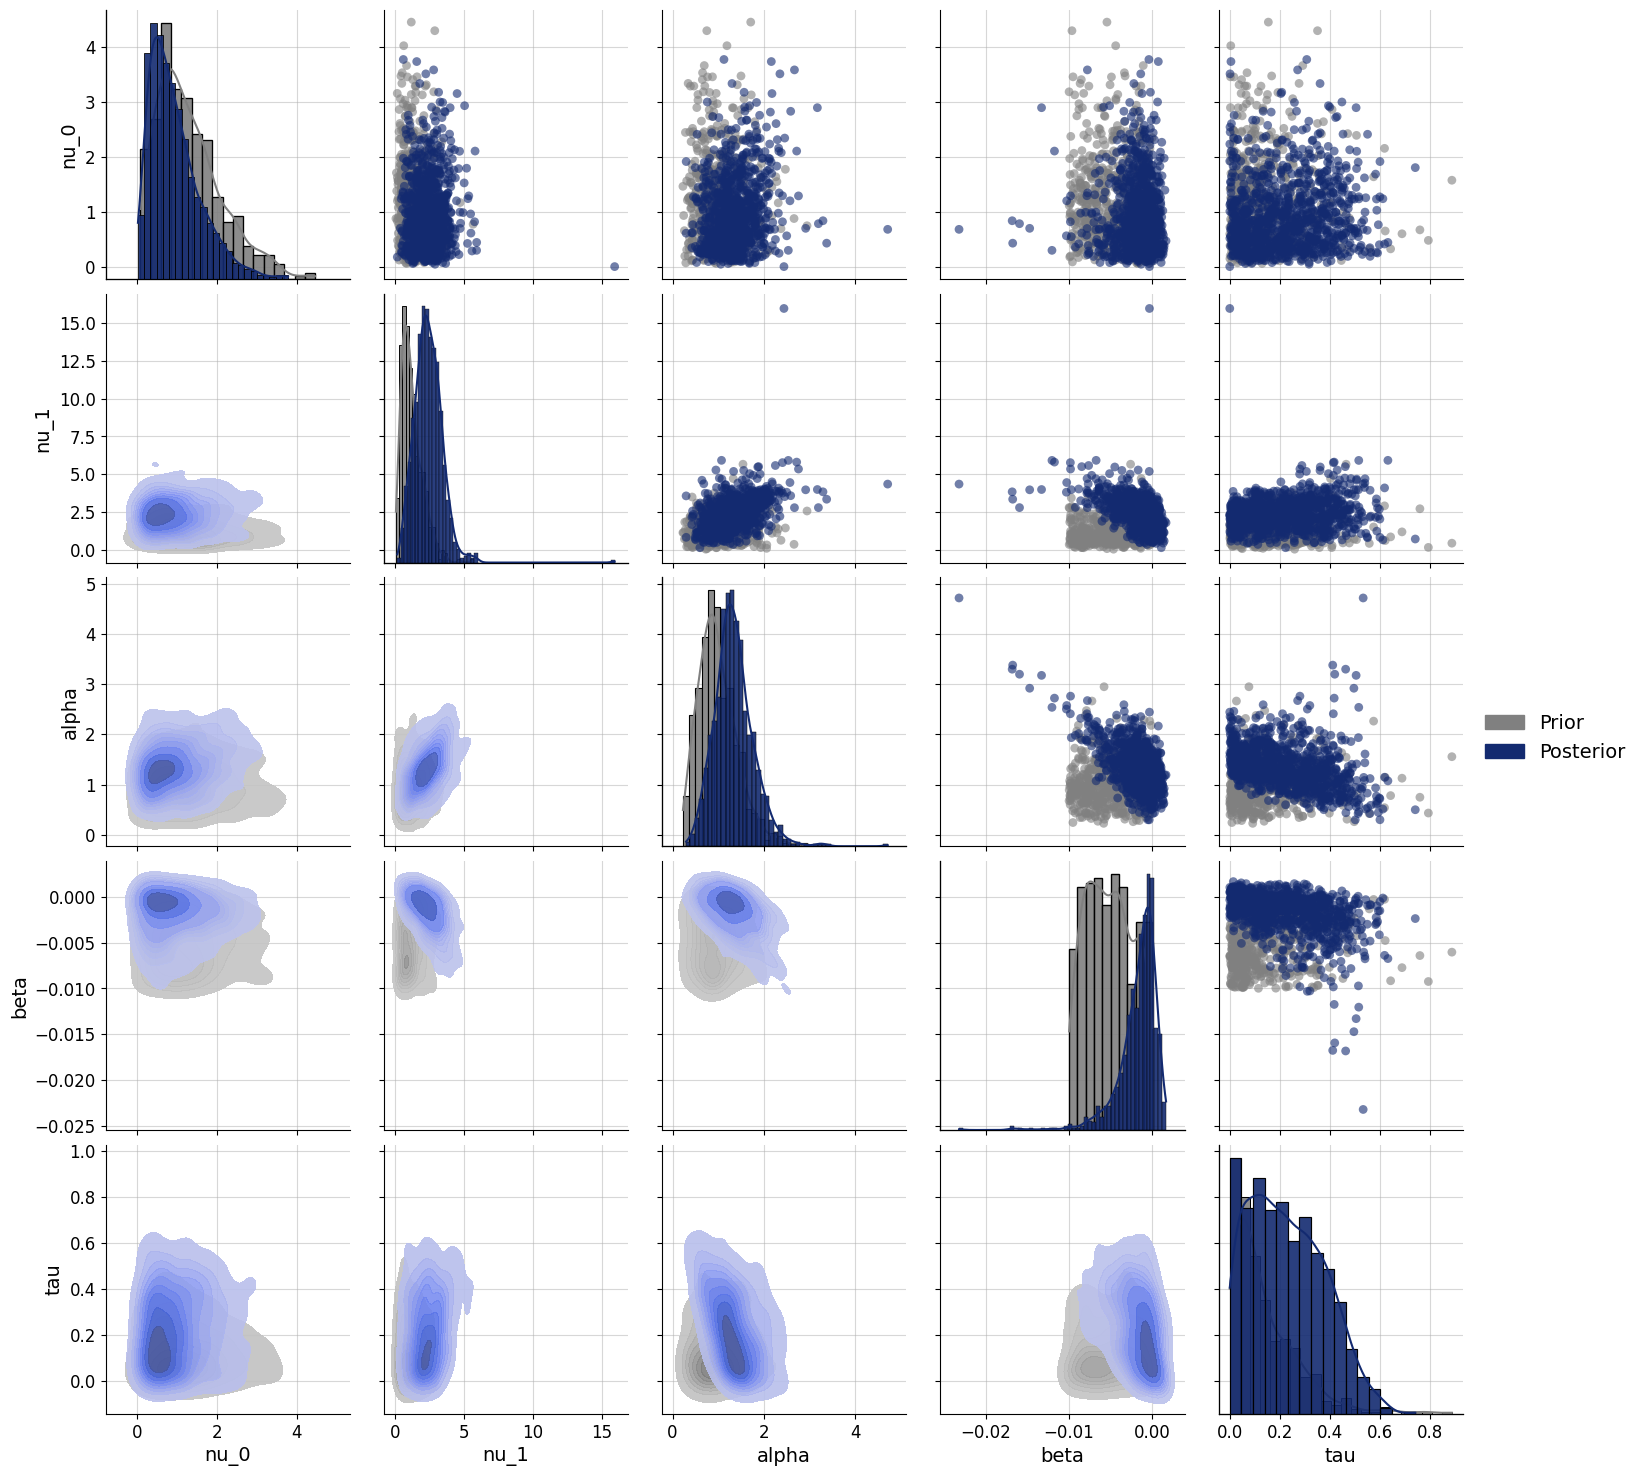

In [240]:
# pick second participant, second condition
posterior = {key: value[3] for key, value in posterior_samples.items()}
f=bf.diagnostics.pairs_posterior(estimates=posterior, priors=priors)

In [202]:
def ecdf(rt, response, observed, **kwargs):
    observed_mask = (observed == 1)
    response_0_mask = ((response == 0) & observed_mask)
    response_1_mask = ((response == 1) & observed_mask)

    response_0_prop = np.sum(response_0_mask) / np.sum(observed_mask)
    response_1_prop = np.sum(response_1_mask) / np.sum(observed_mask)

    response_0_ecdf = stats.ecdf(rt[response_0_mask]).cdf
    response_0_ecdf = response_0_prop * response_0_ecdf.evaluate(np.linspace(0, 1, 101))

    response_1_ecdf = stats.ecdf(rt[response_1_mask]).cdf
    response_1_ecdf = response_1_prop * response_1_ecdf.evaluate(np.linspace(0, 1, 101))

    return response_0_ecdf, response_1_ecdf


Select a participant for whom to display the goodness-of-fit:

In [228]:
data = data_inference_grouped.get_group((1, 'No Deadline'))
plot_data = ecdf(**data)

In [229]:
posterior_predictives = simulator.sample(500, **posterior)

In [230]:
plot_data_predictive = []
for i in range(100):
    x = { key: value[i:i+1,...] for key, value in posterior_predictives.items()}
    plot_data_predictive.append(ecdf(**x))
    
plot_data_predictive = np.array(plot_data_predictive)

In [231]:
plot_data_quantiles = np.quantile(
    plot_data_predictive, 
    q = [0.25, 0.5, 0.75],
    axis=0
)
plot_data_quantiles.shape

(3, 2, 101)

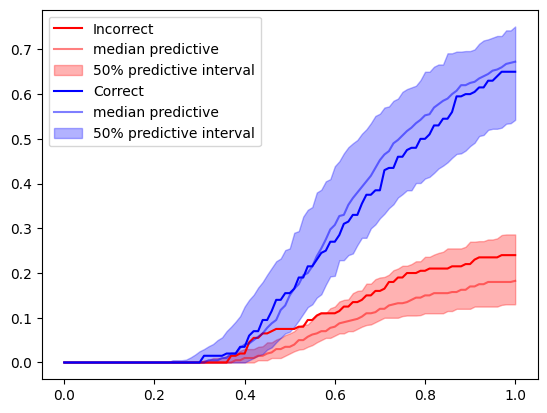

In [232]:
t = np.linspace(0, 1, 101)
cols = ["red", "blue"]
for i, lab in enumerate(["Incorrect", "Correct"]):
    plt.plot(t, plot_data[i], label=lab, color=cols[i])
    plt.plot(t, plot_data_quantiles[1, i, :], color=cols[i], alpha=0.5, label="median predictive")
    plt.fill_between(
        t,
        plot_data_quantiles[0,  i,:],
        plot_data_quantiles[-1, i,:],
        label="50% predictive interval",
        color=cols[i],
        alpha=0.3
    )
f=plt.legend()

The model fits the data ***of this participant*** reasonably well. If you change the participant id or condition, you will see that this is not the case for all here.